In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and filter data
MIN_REVENUE_KSEK = 1_000
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["rr01_ntoms"] >= MIN_REVENUE_KSEK)]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 117 | Samples: 4,710,223
Target distribution:
target_next_year
0    4655040
1      55183
Name: count, dtype: Int64
Imbalance: 84.4:1


In [3]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")

Train: 3,768,178 | Val: 942,045


In [4]:
# Train LightGBM
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = lgb.LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary',
        is_unbalance=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        metric='auc',
        reg_alpha=0.1,
        reg_lambda=0.1
)

start_time = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50, verbose=True), lgb.log_evaluation(100)]
)

training_time = time.time() - start_time
print(f"\nLightGBM training completed in {training_time:.1f}s ({training_time/60:.1f} min)")

print(f"\nBest iteration: {model.best_iteration_}")

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.955073	valid_1's auc: 0.951128
[200]	training's auc: 0.962777	valid_1's auc: 0.955825
[300]	training's auc: 0.96737	valid_1's auc: 0.95759
[400]	training's auc: 0.970608	valid_1's auc: 0.95842
[500]	training's auc: 0.973234	valid_1's auc: 0.958885
[600]	training's auc: 0.975401	valid_1's auc: 0.959046
[700]	training's auc: 0.977404	valid_1's auc: 0.95924
[800]	training's auc: 0.979191	valid_1's auc: 0.9594
[900]	training's auc: 0.980765	valid_1's auc: 0.95947
[1000]	training's auc: 0.982174	valid_1's auc: 0.959555
[1100]	training's auc: 0.983421	valid_1's auc: 0.959606
Early stopping, best iteration is:
[1074]	training's auc: 0.98314	valid_1's auc: 0.95964

LightGBM training completed in 336.6s (5.6 min)

Best iteration: 1074


In [5]:
# Evaluate
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

AUC: 0.9596
PR-AUC: 0.6253

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    931008
         1.0       0.11      0.85      0.19     11037

    accuracy                           0.91    942045
   macro avg       0.55      0.89      0.57    942045
weighted avg       0.99      0.91      0.95    942045


Confusion Matrix:
[[852483  78525]
 [  1603   9434]]


Top 117 Features (by Gain):
                        feature   importance
                    ny_avkegkap 3.428314e+07
  years_since_last_credit_event 1.679405e+07
           ny_skuldgrd_yoy_diff 1.273863e+07
    ratio_cash_liquidity_avg_2y 9.786368e+06
           br09_tillgsu_yoy_pct 7.745867e+06
                        ny_omsf 3.917243e+06
          rr07_rorresul_yoy_pct 3.563563e+06
 ratio_retained_earnings_equity 3.089819e+06
     ratio_share_capital_equity 2.050162e+06
                ny_foradlvpanst 1.298400e+06
          ratio_dividend_payout 1.223477e+06
                     ny_kapomsh 1.144267e+06
ratio_ebit_interest_cov_yoy_pct 1.067937e+06
           ratio_cash_liquidity 1.057489e+06
                       ny_solid 9.555236e+05
                       dpo_days 7.300859e+05
                   ny_nettomarg 7.134192e+05
   ratio_cash_liquidity_yoy_abs 5.883489e+05
            bransch_sni071_konv 5.862796e+05
   ratio_cash_liquidity_yoy_pct 5.538673e+05
              dso_days_yoy_

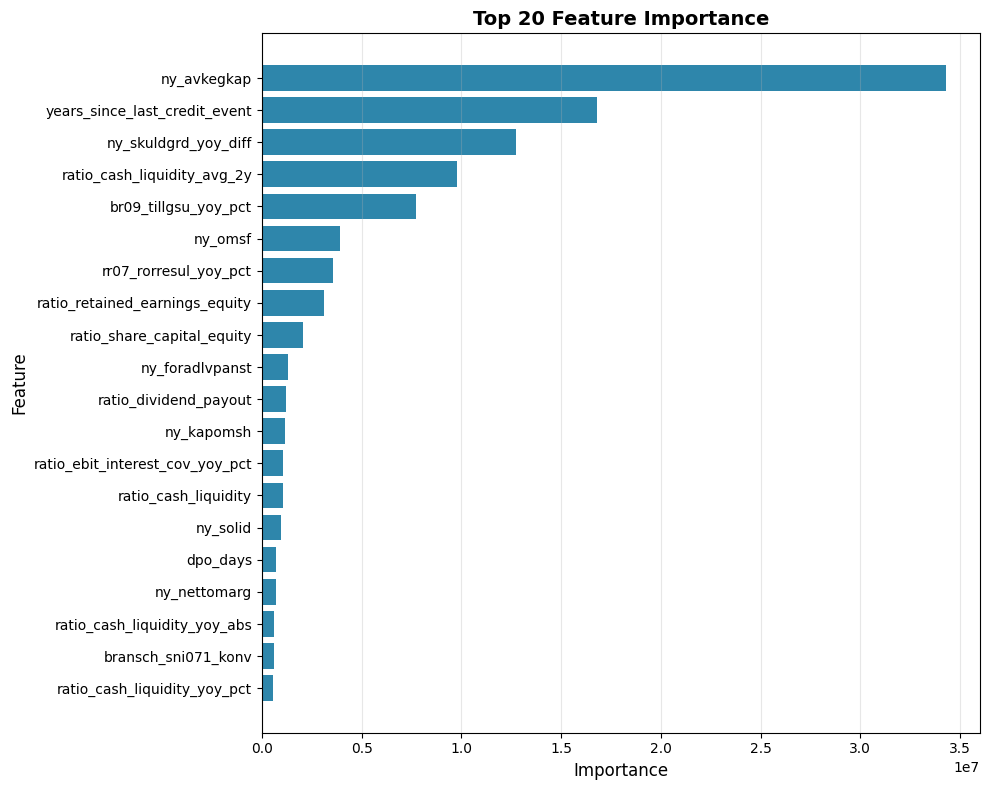


Feature Group Importance Analysis
               group  total_importance  mean_importance  feature_count
               OTHER      4.809176e+07     1.502868e+06             32
               TREND      4.380435e+07     1.042961e+06             42
              CRISIS      1.758394e+07     2.197993e+06              8
               RATIO      9.785190e+06     6.115744e+05             16
               MACRO      1.399546e+06     8.747162e+04             16
LIQUIDITY_EFFICIENCY      1.103038e+06     3.676794e+05              3


In [6]:
# Feature importance analysis
from credit_risk_xai.modeling import get_feature_importance, plot_feature_importance, analyze_feature_groups
from credit_risk_xai.config import (
    RATIO_FEATURE_NAMES, 
    LIQUIDITY_EFFICIENCY_FEATURES, 
    TREND_FEATURE_NAMES, 
    CRISIS_FEATURE_NAMES, 
    MACRO_FEATURE_NAMES
)

# 1. Get LightGBM feature importance (using gain)
importance_df = get_feature_importance(model, X_train, importance_type='gain', top_n=117)
print("Top 117 Features (by Gain):")
print(importance_df.to_string(index=False))

# 2. Visualize feature importance
plot_feature_importance(importance_df, top_n=20, show=True)

# 3. Analyze by feature groups
feature_groups = {
    "RATIO": RATIO_FEATURE_NAMES,
    "LIQUIDITY_EFFICIENCY": LIQUIDITY_EFFICIENCY_FEATURES,
    "TREND": TREND_FEATURE_NAMES,
    "CRISIS": CRISIS_FEATURE_NAMES,
    "MACRO": MACRO_FEATURE_NAMES,
}

group_stats = analyze_feature_groups(model, X_train, feature_groups, importance_type='gain')
print("\n" + "="*80)
print("Feature Group Importance Analysis")
print("="*80)
print(group_stats.to_string(index=False))

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 117 Features (by SHAP):
                        feature  mean_abs_shap
          ratio_dividend_payout       0.470122
                     ny_kapomsh       0.364532
                    ny_avkegkap       0.354856
    ratio_cash_liquidity_avg_2y       0.348840
           ratio_cash_liquidity       0.218092
                    company_age       0.209709
 ratio_retained_earnings_equity       0.178486
                          ny_rs       0.156447
                       dpo_days       0.146961
                ny_foradlvpanst       0.140672
                  bslov_antanst       0.138831
                   br07b_kabasu       0.124326
            bransch_sni071_konv       0.121888
                revenue_cagr_3y       0.107770
            revenue_drawdown_5y       0.106061
ratio_ebit_interest_cov_yoy_pct       0.106035
     ratio_other_operating_cost       0.105559
              ny_solid_yoy_diff       0.104156
                   ny_nettomarg       0.100553
           br09_tillgsu_yoy_pct 

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


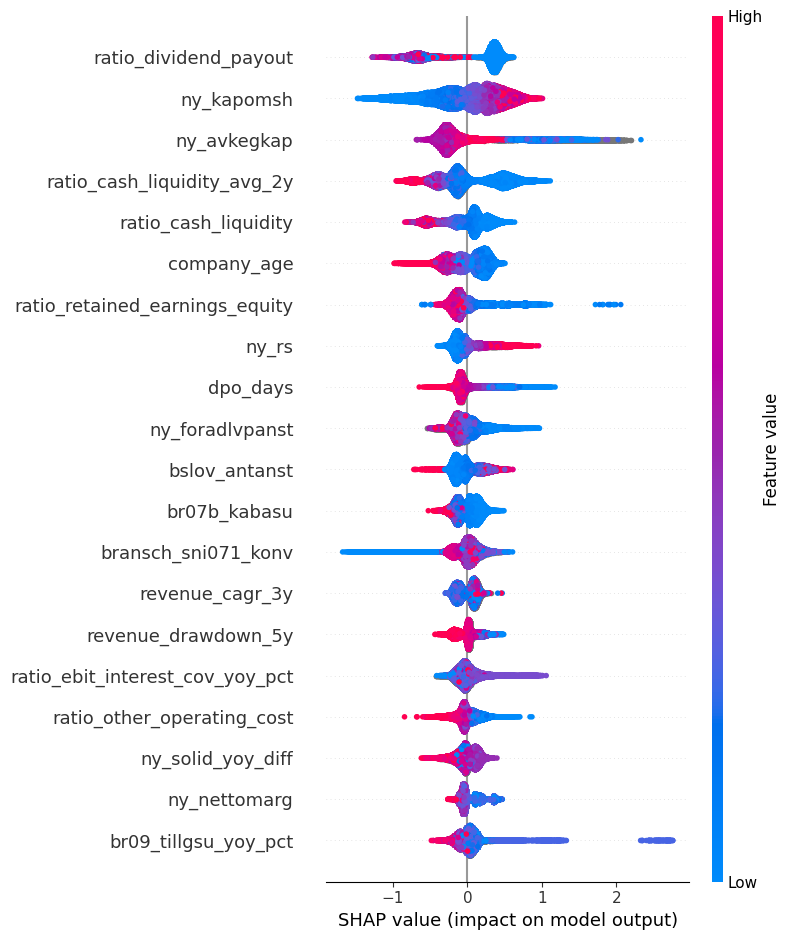

In [7]:
# SHAP analysis
from credit_risk_xai.modeling import get_shap_feature_importance, compute_shap_values
import shap

# 1. Compute SHAP-based feature importance
sample_size = min(100_000, len(X_val))
shap_importance = get_shap_feature_importance(model, X_val, max_samples=sample_size, top_n=117)

print("Top 117 Features (by SHAP):")
print(shap_importance.to_string(index=False))

# 2. Compare native importance vs SHAP
comparison = importance_df.merge(shap_importance, on='feature', how='inner')
comparison['importance_rank'] = comparison['importance'].rank(ascending=False)
comparison['shap_rank'] = comparison['mean_abs_shap'].rank(ascending=False)
comparison['rank_diff'] = abs(comparison['importance_rank'] - comparison['shap_rank'])
comparison = comparison.sort_values('rank_diff', ascending=False)

print("\n" + "="*80)
print("Features with Largest Rank Difference (Gain vs SHAP)")
print("="*80)
print(comparison[['feature', 'importance', 'importance_rank', 'mean_abs_shap', 'shap_rank', 'rank_diff']].head(15).to_string(index=False))

# 3. Generate SHAP summary plot
print(f"\nGenerating SHAP summary plot on {sample_size:,} samples...")
explainer, shap_values, X_sample = compute_shap_values(model, X_val, max_samples=sample_size)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_sample, max_display=20)

In [ ]:
# Correlation analysis by financial statement source
from credit_risk_xai.modeling import (
    get_feature_correlations_by_source,
    find_high_correlations,
    plot_correlation_heatmap,
    summarize_within_group_correlations
)
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# 1. Summary of within-group correlations
print("=" * 90)
print("WITHIN-GROUP CORRELATION SUMMARY")
print("=" * 90)
group_summary = summarize_within_group_correlations(X_train, FEATURE_GROUPS_BY_SOURCE)
print(group_summary.to_string(index=False))

# 2. Compute correlations for each group
corr_by_source = get_feature_correlations_by_source(X_train, FEATURE_GROUPS_BY_SOURCE)

# 3. Find and display high correlations in each group
print("\n" + "=" * 90)
print("HIGH CORRELATIONS BY GROUP (|r| > 0.7)")
print("=" * 90)

for group_name in ["MACRO", "DERIVED_RATIOS", "WORKING_CAPITAL", "OPERATIONAL"]:
    if group_name not in corr_by_source:
        continue
    
    high_corrs = find_high_correlations(corr_by_source[group_name], threshold=0.7, top_n=50)
    
    if len(high_corrs) > 0:
        print(f"\n{group_name} - Top 50 Correlated Pairs:")
        print(high_corrs.to_string(index=False))
    else:
        print(f"\n{group_name} - No correlations above 0.7")

WITHIN-GROUP CORRELATION SUMMARY


KeyboardInterrupt: 

Generating correlation heatmap for MACRO features...


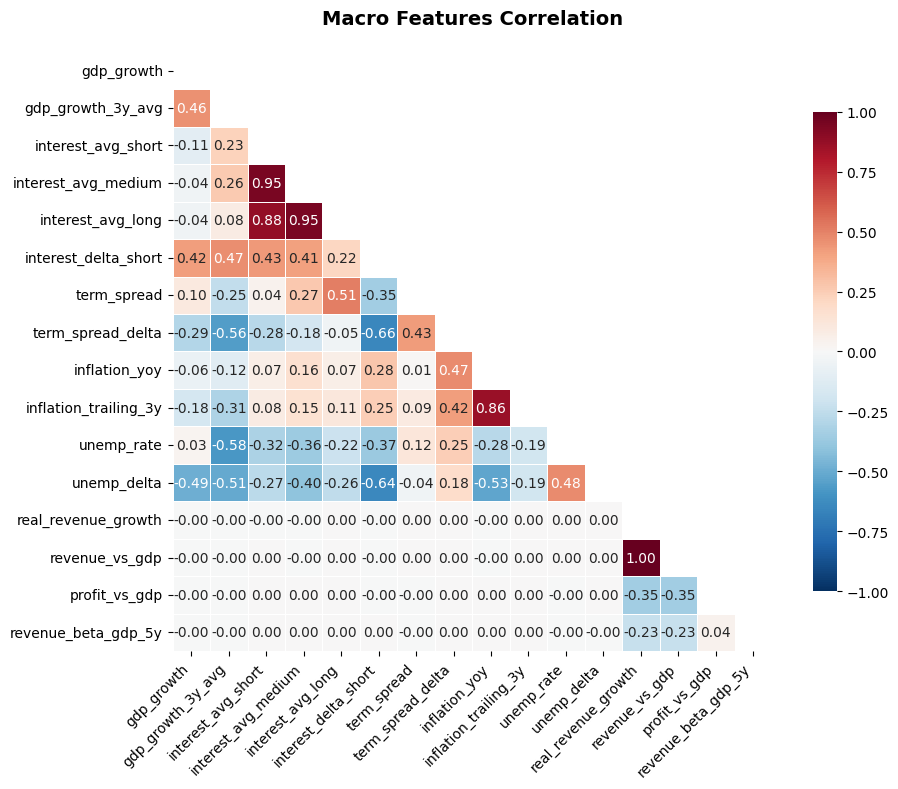


Generating correlation heatmap for WORKING_CAPITAL features...


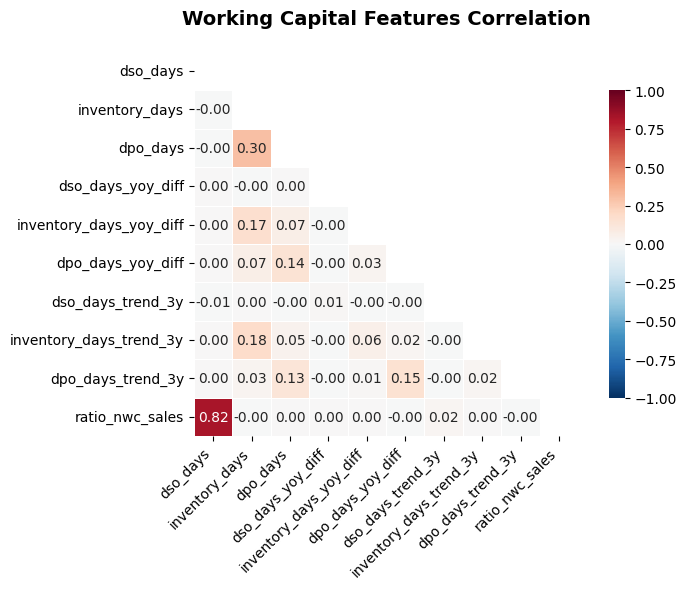


Generating correlation heatmap for DERIVED_RATIOS features...


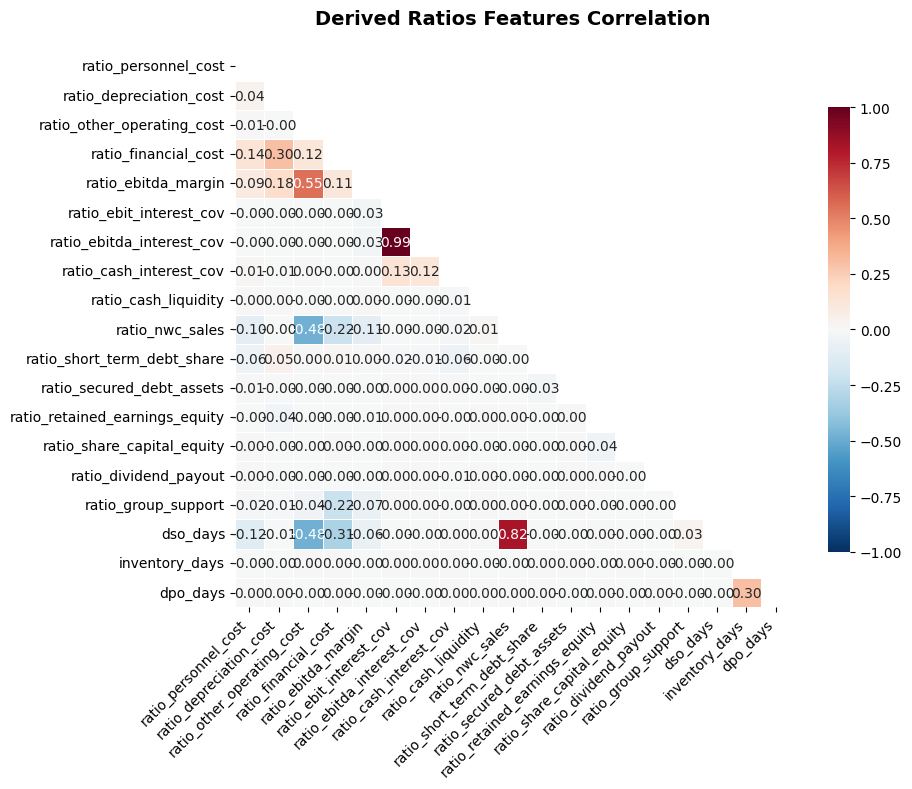


Generating correlation heatmap for OPERATIONAL features...


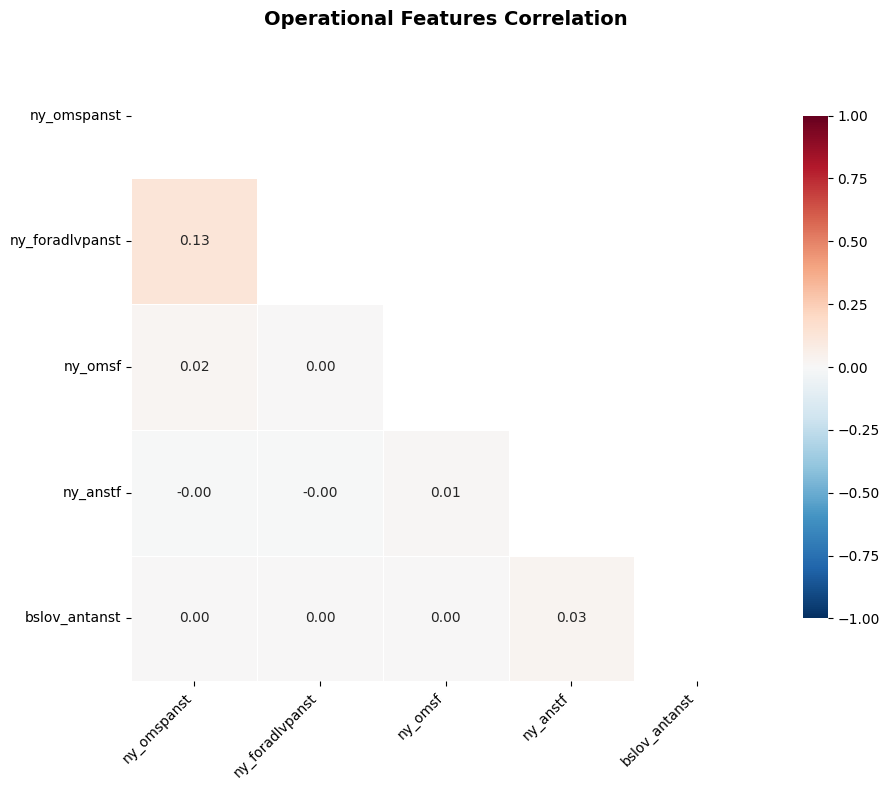

In [9]:
# Visualize correlations for selected groups

if "MACRO" in corr_by_source:
    print("Generating correlation heatmap for MACRO features...")
    plot_correlation_heatmap(
        corr_by_source["MACRO"],
        title="Macro Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "WORKING_CAPITAL" in corr_by_source:
    print("\nGenerating correlation heatmap for WORKING_CAPITAL features...")
    plot_correlation_heatmap(
        corr_by_source["WORKING_CAPITAL"],
        title="Working Capital Features Correlation",
        figsize=(8, 6),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "DERIVED_RATIOS" in corr_by_source:
    print("\nGenerating correlation heatmap for DERIVED_RATIOS features...")
    plot_correlation_heatmap(
        corr_by_source["DERIVED_RATIOS"],
        title="Derived Ratios Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )
if "OPERATIONAL" in corr_by_source:
    print("\nGenerating correlation heatmap for OPERATIONAL features...")
    plot_correlation_heatmap(
        corr_by_source["OPERATIONAL"],
        title="Operational Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

In [10]:
# Feature-target correlation and comparison with importance
from credit_risk_xai.modeling import analyze_correlation_with_target, compare_correlation_vs_importance

# 1. Features most correlated with default risk
print("=" * 90)
print("TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)")
print("=" * 90)
target_corr = analyze_correlation_with_target(X_train, y_train, method='pearson', top_n=30)
print(target_corr.to_string(index=False))

# 2. Compare importance vs correlation - identify interesting patterns
print("\n" + "=" * 90)
print("IMPORTANCE vs CORRELATION COMPARISON")
print("=" * 90)
print("High rank_diff = feature has very different importance rank vs correlation rank")
print("=" * 90)

comparison = compare_correlation_vs_importance(X_train, y_train, importance_df, top_n=30)
print(comparison.to_string(index=False))

# 3. Interpret patterns
print("\n" + "=" * 90)
print("INTERPRETATION PATTERNS")
print("=" * 90)

# High importance but low correlation → nonlinear effects
nonlinear_features = comparison[
    (comparison['importance_rank'] <= 20) & 
    (comparison['corr_rank'] > 40)
].head(10)

if len(nonlinear_features) > 0:
    print("\n🔍 High Importance + Low Correlation (Nonlinear/Interaction Effects):")
    print(nonlinear_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

# High correlation but low importance → redundant features
redundant_features = comparison[
    (comparison['corr_rank'] <= 20) & 
    (comparison['importance_rank'] > 40)
].head(10)

if len(redundant_features) > 0:
    print("\n⚠️  High Correlation + Low Importance (Potentially Redundant):")
    print(redundant_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: 

                      feature  correlation  abs_correlation
          event_count_last_5y     0.343475         0.343475
            event_count_total     0.290860         0.290860
         last_event_within_1y     0.284572         0.284572
         last_event_within_2y     0.284490         0.284490
         last_event_within_3y     0.284440         0.284440
         last_event_within_5y     0.284348         0.284348
                  ever_failed     0.283972         0.283972
                     ny_solid    -0.064991         0.064991
years_since_last_credit_event    -0.054549         0.054549
          revenue_drawdown_5y    -0.036711         0.036711
                    ser_stklf     0.025234         0.025234
               equity_cagr_5y    -0.022985         0.022985
     bransch_borsbransch_konv    -0.022919         0.022919
          bransch_sni071_konv    -0.021803         0.021803
                  company_age    -0.019392         0.019392
               equity_cagr_3y    -0.0130

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: 

                       feature   importance  target_corr  importance_rank  corr_rank  rank_diff
                   ever_failed 0.000000e+00     0.283972            116.5        7.0      109.5
          last_event_within_5y 4.039080e+03     0.284348            115.0        6.0      109.0
          last_event_within_3y 1.754260e+04     0.284440            113.0        5.0      108.0
          last_event_within_2y 2.313203e+04     0.284490            112.0        4.0      108.0
                     ser_stklf 1.552865e+04     0.025234            114.0       11.0      103.0
                       ny_omsf 3.917243e+06    -0.000078              6.0      105.0       99.0
          last_event_within_1y 9.697294e+04     0.284572             94.0        3.0       91.0
ratio_retained_earnings_equity 3.089819e+06    -0.000238              8.0       96.0       88.0
           interest_avg_medium 3.926166e+04     0.011087            109.0       22.0       87.0
             interest_avg_long 5.201191e

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
